<hr />

<div dir="rtl">
    <h2 align="center"><u>מטרת המחקר</u></h2>
    <div>
    מטרת המחקר בשם Subridens לעזור לאנשים עם הפרעות בזיהוי הבעות פנים. דוגמאות להפרעות כאלה הן 
    <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2737612/#b43">הפרעה דכאונית קשה</a>,
    <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2737612/#b32">סכיזופרניה</a>,
    ו<a href="https://doi.org/10.1016/j.psychres.2011.12.042">אישיות נרקיסיסטית</a>.
    בעזרת הפרויקט, יוכלו אנשים עם מחלות אלו להשתמש במחשב שלהם כדי שהוא יבצע את הזיהוי במקומם.
    </div>
</div>

<hr />

<div dir="rtl">
    <h2 align="center"><u>תיאור הנתונים</u></h2>

מאגר הנתונים ששומש במחקר זה נמצא באתר
<a href="https://inc.ucsd.edu/mplab/398/">inc.ucsd.edu</a>
תחת הקישור המצורף לשם האתר. מאגר נתונים זה הוכן על ידי מעבדת 
Machine Perception
וכולל סך הכל 4000 תמונות של בני אדם מסביב כל העולם ביחד עם מידע על האם הם מחייכים וסיבוב הפנים (מה שפחות רלוונטי לנושא הפרויקט)
המעגר בנוי בצורה של תיקיית כל התמונות וקובץ labels.txt שבו לפי סדר המתונות נמצע המידע עליהן.
התמונות אינן אחידות, אך כן יש להן מאפיינים דומים. כל תמונה כוללת בן אדם, שניתן לראות את הפנים שלו. רוב התמונות הן בגודל של 180x192 אך יש גם תמונות שגודלן שונה, לדוגמה 179x192 או אפילו 178x192 (כל היחידות בפיקסלים).
בקובץ הlabels המספר הראשון מסמן האם בתמונה המתאימה הבן האדם מחייך, כאשר 1 מסמן זאת ו0 מסמן שהבן אדם אינו מחייך.
</div>

http://mplab.ucsd.edu, The MPLab GENKI-4K Dataset

<hr />
<h2 align="center"><u>סידור נתונים</u></h2>
<div dir="rtl">כעת כל התמונות נמצאים באותה תיקייה ומצורף קובץ המתאר את המידע בהם. לנוחות, נעביר אותם לשני תיקיות, smiling וnon_smiling, ונוציא את הפנים מהתמונות</div>
<div dir="rtl">יבוא ספריות הנחוצות</div>

In [1]:
import numpy as np
import shutil
import cv2
import os

<div dir="rtl">נעביר את התמונות לתיקיות מתאימות לסוגן</div>

In [2]:
# Define the source and destination directories
DATASET_DIR = "genki4k"
SOURCE_DIR = os.path.join(DATASET_DIR, "files")
LABELS_FILE = os.path.join(DATASET_DIR, "labels.txt")
DESTINATION_DIR = "dataset_raw"

# Create the destination directories if they don't exist
SMILING_DIR = os.path.join(DESTINATION_DIR, "smiling")
NON_SMILING_DIR = os.path.join(DESTINATION_DIR, "non_smiling")
os.makedirs(SMILING_DIR, exist_ok=True)
os.makedirs(NON_SMILING_DIR, exist_ok=True)

# Read the labels from the labels.txt file
with open(LABELS_FILE, "r") as file:
    labels = file.readlines()

# Move the files based on the labels
for i, label in enumerate(labels):
    file_name = "file{:04d}.jpg".format(i + 1)
    # If there would be every any None or something, we would just leave it in the original directory
    if label.startswith("1"):
        shutil.copy(os.path.join(SOURCE_DIR, file_name), os.path.join(SMILING_DIR, file_name))
    elif label.startswith("0"):
        shutil.copy(os.path.join(SOURCE_DIR, file_name), os.path.join(NON_SMILING_DIR, file_name))

print(f"{i+1} files were copied successfully!")


4000 files were copied successfully!


<div dir="rtl">נחלץ את פני בני אדם מהתמונות</div>

In [3]:
# https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

DIR = './dataset_raw'
OUTPUT_DIR = './dataset'

# Loop over the subdirectories in the dataset directory
for sub_dir in os.listdir(DIR):
    sub_dir_path = os.path.join(DIR, sub_dir)
    if not os.path.isdir(sub_dir_path):
        continue

    output_sub_dir = os.path.join(OUTPUT_DIR, sub_dir)
    os.makedirs(output_sub_dir, exist_ok=True)

    for pic in sorted(os.listdir(sub_dir_path)):
        image_file = os.path.join(sub_dir_path, pic)
        try:
            img = cv2.imread(image_file)
            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 5)

            for (x, y, w, h) in faces:
                img_crop = img[y:y+h, x:x+w]
                img_crop_resized = cv2.resize(img_crop, (64, 64))
                output_file = os.path.join(output_sub_dir, pic)
                cv2.imwrite(output_file, img_crop_resized)
        except IOError as e:
            print('Could not read:', image_file, ':', e)

cv2.destroyAllWindows()
print("Done!")

Done!


<h2 align="center"><u>חקר נתונים</u></h2>
<div dir="rtl">יבוא ספריות לחקר נתונים</div>

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<div dir="rtl">מציאת כמות תמונות בכל אחת מהתיקיות בעזרת לולאת for שמירתם בdataframe ובניית גרף עמודות ותרשים עוגה לפי כמותם</div>

In [5]:
df = pd.DataFrame({
    "Type": os.listdir("dataset"),
    "Count": [len(os.listdir("dataset\\"+e)) for e in os.listdir("dataset")]
})
df.style.hide_index()

Type,Count
non_smiling,1768
smiling,2094


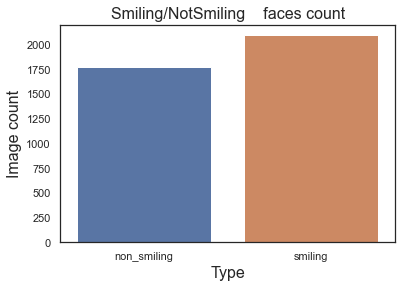

In [6]:
sns.set(style="white")
sns.barplot(x="Type", y="Count", data=df)
plt.title("Smiling/NotSmiling    faces count", fontsize=16)
plt.xlabel("Type", fontsize=16)
plt.ylabel("Image count", fontsize=16)
plt.show()

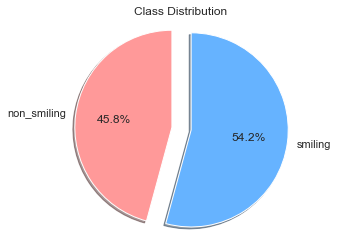

In [7]:
# Calculate total count and class percentages
total_count = df['Count'].sum()
df['Percentage'] = (df['Count'] / total_count) * 100

# Plotting the class distribution
labels = df['Type']
sizes = df['Count']
colors = ['#ff9999', '#66b3ff']
explode = [0.1] * len(labels)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt.title('Class Distribution')
plt.show()

<div dir="rtl">בעזרת ספריית random חישוב של path של 16 תמונות אקראיות מהתיקיית dataset והצגתם</div>

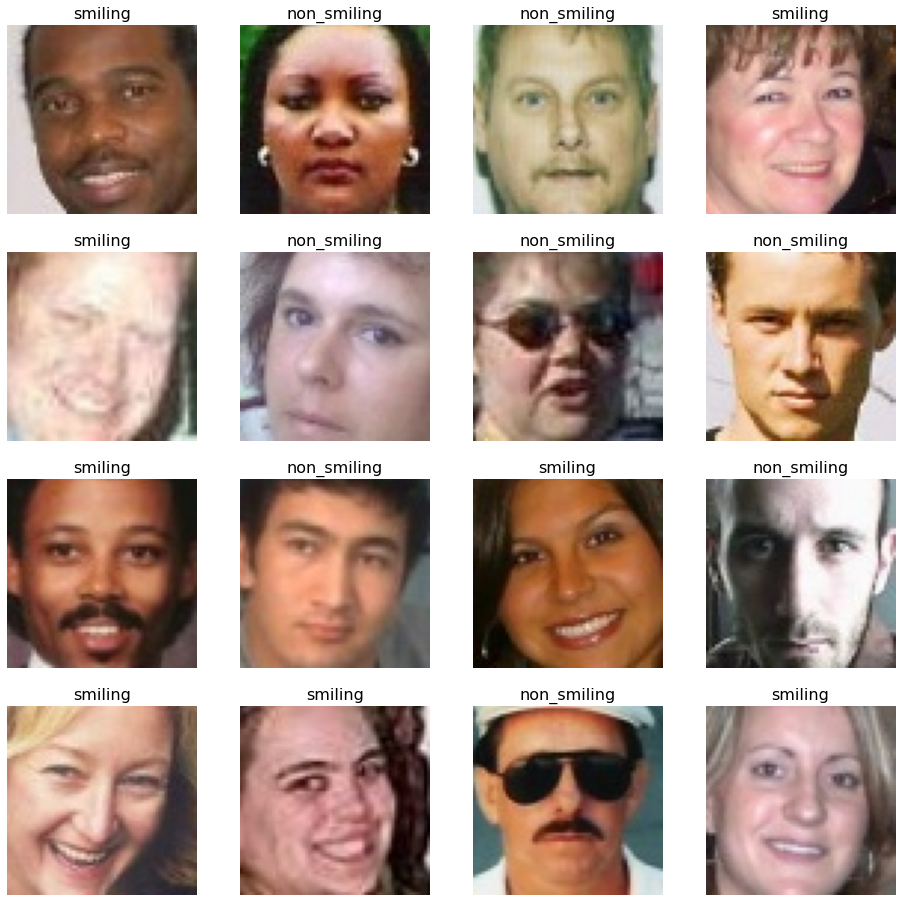

In [8]:
import random

get_random_child_file_path = lambda parent_path: os.path.join(
    parent_path, random.choice(os.listdir(parent_path))
)

f, axarr = plt.subplots(4, 4, figsize=(16, 16))
r, c = 0, 0

for i in range(16):
    if i % 4 == 0 and i != 0:
        r += 1
        c = 0
    emotion = get_random_child_file_path("dataset\\")
    img = cv2.imread(get_random_child_file_path(emotion))[..., ::-1]
    axarr[r, c].imshow(img)
    axarr[r, c].set_title(os.path.basename(emotion), fontsize=16)
    axarr[r, c].axis("off")
    c += 1
plt.show()


<hr />
<h2 align="center" dir="rtl"><u>סידור נתונים לKNN</u></h2>

<div dir="rtl">יבוא ספריות ללמידת מכונה</div>

In [9]:
import mediapipe as mp

<div dir="rtl">הצהרת פונקציות לזיהוי פנים וויזואליזציתם של הנקודות וחלקים של הפנים</div>

In [10]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
def find_face(image):
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5) as face_mesh:
        
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return results
def draw_landmarks(image, landmarks, FACEMESH_TESSELATION=True):
    if (FACEMESH_TESSELATION):
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=landmarks,
        connections=mp_face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    return image

<div dir="rtl">מציאת תמונה אקראית והצגתה עם וללא ויזואליזציה של חלקים מהפנים</div>

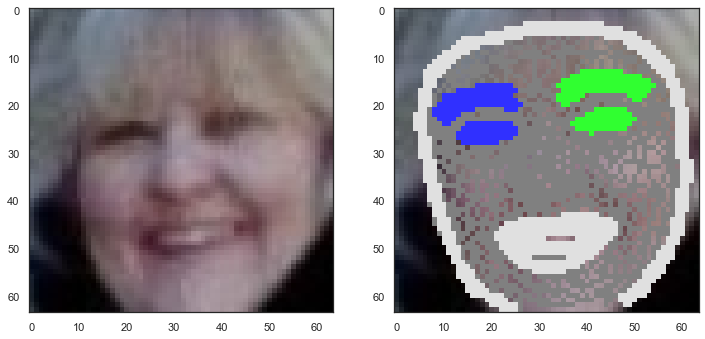

In [11]:
get_random_child_file_path = lambda parent_path: os.path.join(
    parent_path, random.choice(os.listdir(parent_path))
)
while True:
    try:
        path = get_random_child_file_path(get_random_child_file_path("dataset\\"))
        image = cv2.imread(path)[..., ::-1]
        multi_face_landmarks = find_face(image).multi_face_landmarks
        if not multi_face_landmarks:
            raise Exception(f"no face found {path}")
        face_landmarks = multi_face_landmarks[0]
        annotated_image = image.copy()
        draw_landmarks(annotated_image, face_landmarks)

        _, axarr = plt.subplots(1, 2, figsize=(12, 12))
        axarr[0].imshow(image)
        axarr[1].imshow(annotated_image)
        plt.show()
        break
    except Exception as e:
        print(e)


<div dir="rtl">הדפסת הנקודות שהוצגו לעיל כקואורדינטות על התמונה</div>

In [12]:
landmarks_dict = {
    "x": [],
    "y": [],
    "z": [],
}
for lm in face_landmarks.landmark:
    landmarks_dict['x'].append(lm.x)
    landmarks_dict['y'].append(lm.y)
    landmarks_dict['z'].append(lm.z)
pd.DataFrame(landmarks_dict)

,x,y,z
0,0.519526,0.704120,-0.097315
1,0.498676,0.596908,-0.194372
2,0.509441,0.631856,-0.105345
3,0.457651,0.484761,-0.144443
4,0.493201,0.560115,-0.206294
...,...,...,...
463,0.585772,0.388054,0.008593
464,0.565256,0.397276,-0.010476
465,0.552301,0.403313,-0.034860
466,0.759509,0.361294,0.014529


<h3 align="center" dir="rtl"><u>בניית קובץ CSV של Landmarks</u></h3>

<div dir="rtl">יבוא ספריות לבניית קובץ csv אשר ישמש ללמידת מכונה</div>

In [13]:
import csv
from collections import deque

<div dir="rtl">בניית קובץ csv בעזרת לולאת for ופונקציות שהוגדרו לעיל, ושמירת התוצאות בקובץ.</div>

In [14]:
face_not_found = {"smiling": deque(), "non_smiling": deque()}
if os.path.exists(f"landmarks.csv"):
    print(f"landmarks.csv exists")
else:
    with open(f"landmarks.csv", "w", newline="") as f:
        writer = csv.writer(f)

        header = ["smiling"] + [
            "xyz"[i % 3] + str(j)
            for i, j in zip(range(468 * 3), [k for k in range(468) for _ in range(3)])
        ]  # 468 rows * 3 columns
        # header looks like: [smiling, x0, y0, z0, x1, y1, ..., z467]

        writer.writerow(header)

        # for each folder
        for e_i, e_type in enumerate(os.listdir("dataset")):
            path = f"dataset/{e_type}/"
            all_image_names = os.listdir(path)
            print(f"working on {e_type}")
            # for each image
            for image_name in all_image_names:
                image_path = path + image_name
                image = cv2.imread(image_path)

                multi_face_landmarks = find_face(image).multi_face_landmarks
                # if no face found, add to list
                if not multi_face_landmarks:
                    face_not_found[e_type].append(image_name)
                    continue
                y = [i.y for i in multi_face_landmarks[0].landmark]
                x = [i.x for i in multi_face_landmarks[0].landmark]
                z = [i.z for i in multi_face_landmarks[0].landmark]

                data = np.array(list(zip(x, y, z))).reshape(-1)
                data = np.concatenate(([e_i], data))
                writer.writerow(data)
    print(
        "Done, face wasn't found",
        " and ".join(
            [
                f'{len(deq)} times out of {len(os.listdir("dataset/"+key))} in ' + key
                for key, deq in list(face_not_found.items())
            ]
        ),
    )


working on non_smiling
working on smiling
Done, face wasn't found 41 times out of 2094 in smiling and 56 times out of 1768 in non_smiling


<div dir="rtl">שמירת שמות של הקבצים עם פנים שלא זיוהתו.</div>

In [15]:

    
if os.path.exists(f"no_face_found.csv"):
    print(f"no_face_found.csv exists")
else: 
    with open(f"no_face_found.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['type', 'image_name'])
        for type in os.listdir('dataset'):
            writer.writerows(
                [
                    [type, filename] for filename in face_not_found[type]
                ]
            )
    print("Done!")

Done!


<div dir="rtl">טעינת הdataset והדפסה של חמש שורות הראשונות שלו</div>

In [16]:
df = pd.read_csv('landmarks.csv')

In [17]:
df.head()

,smiling,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z464,x465,y465,z465,x466,y466,z466,x467,y467,z467
0,0.0,0.512860,0.801256,-0.079911,0.478800,0.687679,-0.196836,0.495058,0.713651,-0.091552,...,-0.029768,0.517443,0.418260,-0.054247,0.745056,0.335331,-0.006745,0.761812,0.318332,-0.008973
1,0.0,0.458710,0.716279,-0.139674,0.455302,0.558414,-0.188374,0.462837,0.616632,-0.115854,...,0.038995,0.544449,0.411332,0.014768,0.752313,0.405296,0.062095,0.775309,0.387539,0.063043
2,0.0,0.494123,0.744723,-0.082820,0.489723,0.617594,-0.178352,0.493608,0.650387,-0.089039,...,-0.006312,0.550793,0.399359,-0.032165,0.735988,0.366764,0.026073,0.752809,0.359398,0.025326
3,0.0,0.525435,0.788554,-0.059923,0.473080,0.683601,-0.161508,0.503124,0.703846,-0.072235,...,-0.050988,0.519204,0.434204,-0.069086,0.714878,0.338110,-0.063315,0.731623,0.317301,-0.068692
4,0.0,0.460650,0.687270,-0.126245,0.442392,0.564455,-0.207661,0.456081,0.606723,-0.117192,...,0.010569,0.529123,0.373745,-0.014734,0.761742,0.343348,0.029913,0.783799,0.325894,0.029632


<div dir="rtl">ערבוב המידע והצגת הdataframe המעורבב</div>

In [18]:
df_shuffled = df.sample(frac=1, random_state=1).reset_index(drop=True)

In [19]:
df_shuffled.head()

,smiling,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z464,x465,y465,z465,x466,y466,z466,x467,y467,z467
0,0.0,0.467967,0.752674,-0.045890,0.449983,0.654754,-0.166388,0.465956,0.670303,-0.066852,...,-0.063343,0.531303,0.404440,-0.081374,0.749215,0.341284,-0.063423,0.767701,0.320463,-0.067489
1,1.0,0.475245,0.680059,-0.102228,0.486234,0.590382,-0.185761,0.483466,0.623475,-0.106736,...,0.012716,0.560278,0.414946,-0.013753,0.741418,0.407960,0.052551,0.763066,0.395980,0.053630
2,0.0,0.454265,0.829784,-0.100065,0.412474,0.691462,-0.188713,0.450528,0.726283,-0.098147,...,-0.030679,0.529592,0.442744,-0.051347,0.773721,0.370068,-0.061936,0.797303,0.347332,-0.069330
3,1.0,0.448689,0.678240,-0.093199,0.437283,0.592147,-0.192775,0.447215,0.621037,-0.102245,...,-0.011265,0.537863,0.381446,-0.035747,0.749204,0.359881,0.008783,0.771190,0.348099,0.008090
4,1.0,0.510127,0.662657,-0.138946,0.511150,0.531744,-0.215343,0.509787,0.581297,-0.129935,...,0.031715,0.573509,0.369690,0.002062,0.773747,0.360364,0.083608,0.796624,0.342375,0.087279


<div dir="rtl">חלוקת הנתונים לקלט ופלט רצוי</div>

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != "smiling"].values,
    df["smiling"].values,
    test_size=0.2,
    random_state=1,
)


In [22]:
y_train_counts = np.unique(y_train, return_counts=True)[1]
y_test_counts = np.unique(y_test, return_counts=True)[1]

pd.DataFrame(
    {"train": y_train_counts, "test": y_test_counts}, index=["Not Smiling", "Smiling"]
)


,train,test
Not Smiling,1360,352
Smiling,1652,401


In [23]:
print(f"train: {y_train.shape[0]} rows\ntest:  {y_test.shape[0]} rows")

train: 3012 rows
test:  753 rows


<h3 align="center" dir="rtl"><u>בניית מודל KNN</u></h3>

<div dir="rtl">יבוא ספריות ללמידת מכונה</div>

In [24]:
from sklearn.neighbors import KNeighborsClassifier
import pickle

<div dir="rtl">אימון המודל עם היפרפרמטר k בטווח בין 1 ל-53</div>

In [25]:
k_neighbors_test_df = pd.DataFrame({"k": [], "accuracy": []})
min_k, max_k, step = 1, 53, 2
print("calculating...")
print("[", end="")
for k in range(min_k, max_k+step, step):
    test_knn = KNeighborsClassifier(n_neighbors=k)
    test_knn.fit(X_train, y_train)
    accuracy = test_knn.score(X_test, y_test)
    print("▮",end="")
    
    k_neighbors_test_df = k_neighbors_test_df.append(
        {"k": k, "accuracy": accuracy}, ignore_index=True
    )
print("]")
k_neighbors_test_df


calculating...
[▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮]


,k,accuracy
0,1.0,0.807437
1,3.0,0.822045
2,5.0,0.828685
3,7.0,0.822045
4,9.0,0.819389
5,11.0,0.818061
6,13.0,0.816733
7,15.0,0.826029
8,17.0,0.820717
9,19.0,0.820717


<div dir="rtl">ויזואליזציה של דיוק המודל עם היפרפרמטרים k שונים</div>

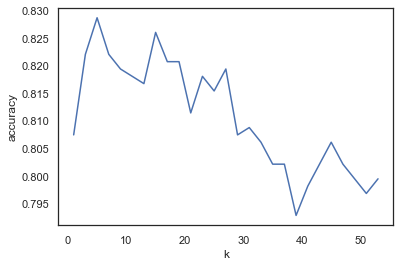

In [26]:
sns.lineplot(data=k_neighbors_test_df, x="k", y="accuracy")
plt.show()

In [27]:
best_row = k_neighbors_test_df.iloc[k_neighbors_test_df["accuracy"].idxmax()]
best_k = int(best_row["k"])
best_acc = best_row["accuracy"]
print(f"Best K found!\nk {best_k} with accuracy {round(best_acc*100,3)}%")

Best K found!
k 5 with accuracy 82.869%


<div dir="rtl">בניית המודל</div>

In [28]:
KNN = None
if os.path.exists("subridens.knn.pickle"):
    with open("subridens.knn.pickle", "rb") as f:
        KNN = pickle.load(f)
else:
    KNN = KNeighborsClassifier(n_neighbors=best_k)
    KNN.fit(X_train, y_train)
    
    with open("subridens.knn.pickle", "wb") as f:
        pickle.dump(KNN, f)

<h3 align="center" dir="rtl"><u>בדיקת מודל KNN</u></h3>

<div dir="rtl">יבוא ספריות לבדיקת המודל</div>

In [29]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score,
)


<div dir="rtl">חישוב הדיוק וויזואליזציה של בדיקת המודל</div>

In [30]:
print("Test Accuracy: ", KNN.score(X_test, y_test))
print("Train Accuracy: ", KNN.score(X_train, y_train))
predictions = KNN.predict(X_test)
prf = precision_recall_fscore_support(y_test, predictions, average="weighted")
print(
    # proportion of correctly predicted positive instances (true positives) out of allinstances predicted as
    # positive
    # besicaly how good the model is in answering right (with true)
    f"precision: {(prf[0])*100:.3f}%",  # precision = True Positives / (True Positives + False Positives)
    # proportion of correctly predicted positive instances (true positives) out of all actual positive
    # instances
    # besicaly how good the model is in answering true
    f"recall: {(prf[1])*100:.3f}%",  # recall = True Positives / (True Positives + False Negatives)
    # harmonic mean of precision and recall, giving equal weight to both (F1 score)
    # so like a measurment that tests both
    f"F1 score: {(prf[2])*100:.3f}%",  # F1 score = 2 * ((precision * recall) / (precision + recall))
    sep="\n",
)


Test Accuracy:  0.8286852589641435
Train Accuracy:  0.8937583001328021
precision: 82.896%
recall: 82.869%
F1 score: 82.829%


In [31]:
y_pred_proba = KNN.predict_proba(X_test)

In [32]:
# FPR: False Positive Rate, TPR: True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])  # Positive class probabilities
# like we calculate how the recall (how good the model is in answering true) changes with specificity
# which is basicaly how many false positivies there are per one negative
# (how bad the model is in answering false)

In [33]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
roc_auc # Area under the roc curve

0.9006213160281116

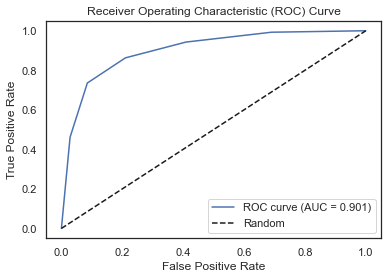

In [34]:
# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate') # Aka 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

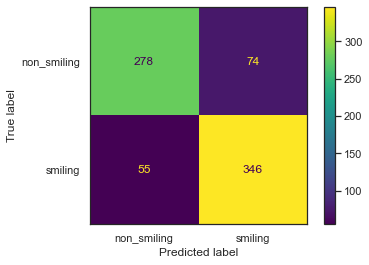

In [35]:
ConfusionMatrixDisplay.from_estimator(KNN, X_test, y_test, display_labels=os.listdir("dataset"))
plt.show()

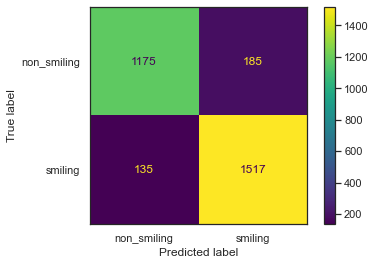

In [36]:
ConfusionMatrixDisplay.from_estimator(KNN, X_train, y_train, display_labels=os.listdir("dataset"))
plt.show()

<div dir="rtl">הייתי רוצה לקבל דיוק גבוה יותר לכן אני הולך לנסות מודל אחר</div>

<h3 align="center"><u>Neural Network</u></h3>
<div dir="rtl">נשתמש במודל CNN</div>

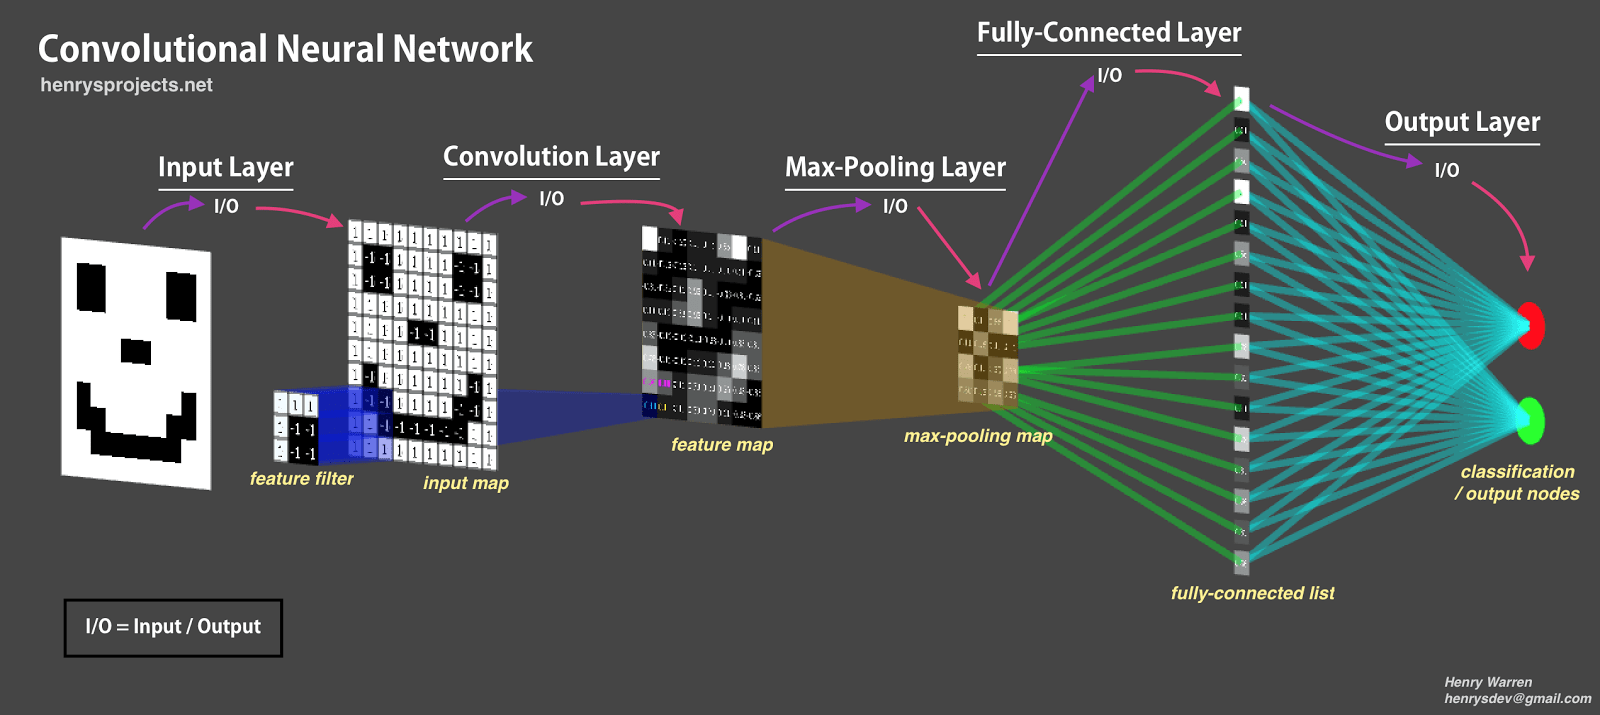

---

<div dir="rtl">יבוא ספריות הנחוצות</div>

In [37]:
import os
import keras
import numpy as np
import tensorflow as tf
from tensorflow import keras

<h3 align="center" dir="rtl"><u>הכנת המידע לCNN</u></h3>

In [38]:
from keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import ResNet50

<div dir="rtl">"יבוא" המידע מהתקיות בעזרת ImageDataGenerator</div>

In [39]:
# randomly transforms the data, like spin, mirror, crop etc to make it more diffrent
IDG = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    rescale=1 / 255,
)

In [40]:
# randomly transform the data, like spin, mirror, crop, shuffle and etc to make it more diffrent
train = IDG.flow_from_directory(
    "dataset/",
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=128,
    class_mode="categorical",
    subset="training",
    shuffle=True,
)


test = IDG.flow_from_directory(
    "dataset/",
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=128,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
)

Found 3091 images belonging to 2 classes.
Found 771 images belonging to 2 classes.


<div dir="rtl">מציאת ה"משקל" של המידע לפי כמותו</div>

In [41]:
counter = Counter(train.classes)
class_weights = { i: float(max(counter.values())) / img_count for i, img_count in counter.items() }
class_weights

{0: 1.184452296819788, 1: 1.0}

<h3 align="center" dir="rtl"><u>בניית מודל CNN וכיוון היפר פרמטרים</u></h3>
<div dir="rtl">יבוא ספריות הנחוצות</div>

In [42]:
from tensorflow.keras import layers
from keras_tuner.tuners import GridSearch
from keras import callbacks

<div dir="rtl">נגדיר פונקציה שאיתה נוכל למצוא את ההיפר פרמטרים הטובים ביותר</div>

In [43]:
def build_model(hp):
    model = keras.Sequential()
    model.add(
        keras.applications.ResNet50(
            input_shape=(64, 64, 3), weights="imagenet", include_top=False
        )
    )
    model.add(keras.layers.GlobalMaxPooling2D())
    model.add(keras.layers.Dropout(hp.Float("dropout", 0.0, 0.3, step=0.1)))
    model.add(keras.layers.Dense(2, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


<div dir="rtl">נבנה tuner שבעזרת הפונקציה ימצא את ההיפר פרמטרים</div>

In [44]:
tuner = GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,           
    overwrite=True           
)

# Define the search space for each hyperparameter
tuner.search_space_summary()

Search space summary
Default search space size: 2
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


<div dir="rtl">נשתמש בModelCheckpoint במטרה לקחת את המודל בepoch הטוב ביותר</div>

In [45]:
checkpoint = callbacks.ModelCheckpoint(filepath='CNN/checkpoints.h5',
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)

<div dir="rtl">נתחיל את החיפוש</div>

In [46]:
tuner.search(
    train,
    validation_data=test,
    epochs=100,
    steps_per_epoch=train.n // train.batch_size,
    validation_steps=test.n // test.batch_size,
    callbacks=[checkpoint]
)

Trial 9 Complete [00h 09m 37s]
val_accuracy: 0.9231770634651184

Best val_accuracy So Far: 0.9388020634651184
Total elapsed time: 01h 18m 53s
INFO:tensorflow:Oracle triggered exit


<div dir="rtl">נבנה את המודל עם ההיפר פרמטרים הטובים ביותר</div>

In [47]:
if os.path.exists("CNN/subridens.cnn.h5"):
    model = keras.models.load_model("CNN/subridens.cnn.h5")
else:
    model = tuner.get_best_models(1)[0]
    model.save("CNN/subridens.cnn.h5")


<h3 align="center" dir="rtl"><u>בדיקת מודל CNN</u></h3>

<div dir="rtl">יבוא ספריות הנחוצות</div>

In [48]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import numpy as np


<div dir="rtl">קבלת הסיווג של המודל למידעת בדיקה ובדיקת נכונות המודל</div>

In [49]:
raw_predictions = model.predict(test)

7/7 [==============================] - 2s 211ms/step


In [50]:
# FPR: False Positive Rate, TPR: True Positive Rate
fpr, tpr, thresholds = roc_curve(test.classes, raw_predictions[:, 1])  # Positive class probabilities
# like we calculate how the recall (how good the model is in answering true) changes with specificity
# which is basicaly how many false positivies there are per one negative
# (how bad the model is in answering false)

In [51]:
roc_auc = roc_auc_score(test.classes, raw_predictions[:, 1])
roc_auc # Area under the roc curve

0.9747685593071012

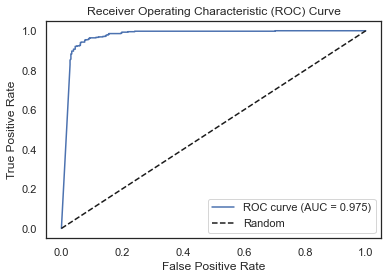

In [52]:
# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate') # Aka 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<div dir="rtl">מצאית גבול סיווג הטוב ביותר</div>

In [53]:
# Find one that has most true positives with least false positives
best_threshold = thresholds[np.argmax(tpr - fpr)]
print("Best threshold:", best_threshold)

Best threshold: 0.7210124


In [54]:
def create_prediction_function(threshold):
    def prediction(raw_prediction):
        # if we are threshold% sure this is smiling, say it's smiling
        return raw_prediction[1] >= threshold
    
    return prediction


In [55]:
prediction_reading = create_prediction_function(best_threshold)

In [56]:
predictions = [prediction_reading(p) for p in raw_predictions]

accuracy = np.sum(np.array(predictions) == np.array(test.classes)) / len(test.classes)
# proportion of correctly classified instances (true positives and true negatives) out of all instances
print(f"accuracy: {(accuracy)*100:.3f}%") 

prf = precision_recall_fscore_support(test.classes, predictions, average="weighted")
print(
    # proportion of correctly predicted positive instances (true positives) out of all instances predicted as
    # positive
    # besicaly how good the model is in answering right (with true)
    f"precision: {(prf[0])*100:.3f}%",  # precision = True Positives / (True Positives + False Positives)

    # proportion of correctly predicted positive instances (true positives) out of all actual positive
    # instances
    # besicaly how good the model is in answering true
    f"recall: {(prf[1])*100:.3f}%",  # recall = True Positives / (True Positives + False Negatives)

    # harmonic mean of precision and recall, giving equal weight to both (F1 score)
    # so like a measurment that tests both
    f"F1 score: {(prf[2])*100:.3f}%",  # F1 score = 2 * ((precision * recall) / (precision + recall))
    sep="\n",
)

accuracy: 93.904%
precision: 93.911%
recall: 93.904%
F1 score: 93.906%


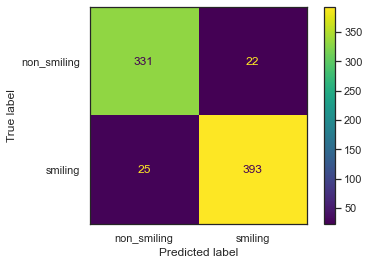

In [57]:
confusion_mat = confusion_matrix(test.classes, predictions)
ConfusionMatrixDisplay(confusion_mat, display_labels=os.listdir("dataset")).plot()
plt.show()


In [58]:
guess_acc = 1/2
knn_acc = KNN.score(X_test, y_test)
cnn_acc = accuracy
print(f"Guessing accuracy: {round(guess_acc*100, 3)}%")
print(f"KNN accuracy: {round(knn_acc*100, 3)}%")
print(f"CNN accuracy: {round(cnn_acc*100, 3)}%")

Guessing accuracy: 50.0%
KNN accuracy: 82.869%
CNN accuracy: 93.904%


<h3 align="center"><u>בדיקה בלייב</u></h3>

<div dir="rtl">יבוא הספריות שנשתמש בהן</div>

In [59]:
import cv2
import numpy as np
import imageio

<div dir="rtl">יצירת פונקציה אשר תוכל להוציא את הפנים ממסגרת הוידאו</div>

In [60]:
# Load the pre-trained face cascade classifier
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Function to detect faces in an image
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

<div dir="rtl">יצירת פונקציה אשר תשתמש בבינה מלאכותית כדי לזהות את מצב הרוח של הבן אדם</div>

In [61]:
# Function to classify the facial expression as smiling or not
def classify_smile(image, model):
    # Preprocess the image
    image = cv2.resize(image, (64, 64))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    # Predict the smile using the CNN model
    return np.argmax(model.predict(image)[0])

<div dir="rtl">התחלת הצילום ושמירת התוצאה בgif</div>

In [62]:
# Open the video capture
cap = cv2.VideoCapture(0)

# Define the GIF output path and parameters
output_path = 'live_test.gif'
fps = 10  # Frames per second
duration = 1000 * 1/fps

# Create an empty list to store the frames for the GIF
frames = []

while True:
    # Read the frame from the video capture
    ret, frame = cap.read()

    # Detect faces in the frame
    faces = detect_faces(frame)

    for (x, y, w, h) in faces:
        # Extract the face region
        face_image = frame[y:y+h, x:x+w]

        # Classify the smile
        is_smiling = classify_smile(face_image, model)

        # Draw a rectangle around the face
        color = (0, 255, 0) if is_smiling else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

        # Display the smile prediction
        label = "Smiling" if is_smiling else "Not Smiling"
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Append the frame to the list
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Display the resulting frame
    cv2.imshow('Smile Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the window
cap.release()
cv2.destroyAllWindows()

# Save the frames as a GIF using imageio
imageio.mimsave(output_path, frames, duration=duration)

print(f"Saved GIF at: {output_path}")
